# <font color=#cd0000> Propósito principal </font>
- La idea de este librillo es preparar el entorno para realizar pruebas para Epilepsy a ser clasificado por una codificación simbólica con ``Tendencia`` aplicada a SMTS

## <font color=#cd0000> Leyenda </font>
- Los apartados titulados con el código de colores HEX: `#cd0000` serán apartados que tendrán todos los librillos, en concreto, aquellos especificados en el apartado `Síntesis de los criterios usados` del trabajo.
- Los apartados titulados con el código de colores HEX: `#2451ff` serán apartados de conclusiones propias de este librillo resultado de aplicar un estudio personalizado para cada planteamiento.

# <font color=#cd0000> Prerrequisitos </font>
## <font color=#cd0000> Entorno de ejecución </font>
- Cambiamos el directorio raíz del librillo para acceder cómodamente a las funciones de utilidad.

In [1]:
import os

os.chdir('../../../../')
os.listdir()


['.git',
 '.gitignore',
 '.gitmodules',
 'data',
 'pkl',
 'Pruebas',
 'README.md',
 'smts_implementation',
 'utils']

## <font color=#cd0000> Constantes y variables predefinidas </font>

In [32]:
EPILEPSY_PATH = "data/epilepsy"

DATA_TO_SAVE = "Epilepsy"

PKL_DIR = "pkl/SMTS/Epilepsy/"
PKL_NAME = "epilepsy_SMTS_codifsimb_trend.pkl"

SEED = 1


# <font color=#cd0000> Carga del Dataset </font>

In [3]:
from utils.load_data import import_epilepsy_dataset

train, test = import_epilepsy_dataset(EPILEPSY_PATH)

In [4]:
train.reset_changes()
test.reset_changes()


# <font color=#cd0000> Preprocesamiento </font>

## <font color=#cd0000> Eliminación de datos inválidos y valores atípicos </font>
- Eliminaremos aquellos valores fuera de los percentiles 5 y 95.
- El grado de outliers mínimo en, al menos, una dimensión para eliminar una serie temporal será del 80% (si más del 80% de los datos son anómalos descartamos la serie).
  - A pesar de que esto pueda parecer muy grande debemos comprender que, la probabilidad con la que aparezca ruido en una de las dimensiones de una serie temporal multivariada, es muy alta (tenemos varias series temporales con ruido cada una).

In [5]:
train.remove_outliers(
    headers=train.get_derived_data_columns()['attrs'],
    outliers_limit=.8
)

test.remove_outliers(
    headers=test.get_derived_data_columns()['attrs'],
    outliers_limit=.8
)


In [6]:
import pandas as pd

# Remaining series
print("Train: Previous number of series: {}".format(
    len(pd.unique(train.original_data['id']))))
print("Train: Actual number of series: {}".format(
    len(pd.unique(train.derived_data['id']))))

print("Test: Previous number of series: {}".format(
    len(pd.unique(test.original_data['id']))))
print("Test: Actual number of series: {}".format(
    len(pd.unique(test.derived_data['id']))))


Train: Previous number of series: 137
Train: Actual number of series: 137
Test: Previous number of series: 138
Test: Actual number of series: 138


## <font color=#cd0000> Resoluciones a aplicar </font>
- Como concluimos en el análisis en profundidad, mantendremos la resolución original.

In [7]:
# Nothing to see here


# <font color=#cd0000> División en ventanas </font>
- Como concluimos en el análisis en profundidad no aplicaremos enventanado pues las series son muy cortas y, aplicar un enventanado que divida las series en subseries, daría como resultado series mucho más cortas de las que sería más difícil extraer patrones en el caso de clases como ``epilepsy``, por ejemplo.

In [8]:
# Nothing to see here

## <font color=#cd0000> Codificación </font>

In [9]:
from utils.codifications import temporal_trend_fn

train.apply_codifications([temporal_trend_fn])
test.apply_codifications([temporal_trend_fn])


# <font color=#cd0000> Preparación de los datos </font>

In [10]:
X_train = train.derived_data.drop(['TimeStamp', 'class'], axis=1)
X_test = test.derived_data.drop(['TimeStamp', 'class'], axis=1)

y_train = train.derived_data['class'].to_numpy()
y_test = test.derived_data['class'].to_numpy()


## <font color=#cd0000> Técnicas de balanceo </font>

### <font color=#cd0000> Asignación de pesos a las clases </font>

In [11]:
import numpy as np
from sklearn.utils import compute_class_weight

class_weights = compute_class_weight(
    'balanced', classes=np.unique(y_train), y=y_train)
class_weights = {'epilepsy': class_weights[0], 'running': class_weights[1],
                 'sawing': class_weights[2], 'walking': class_weights[3]}


# <font color=#cd0000> Diseño de la topología del bosque </font>
- Número de árboles inicial recomendado
- Número de símbolos inicial recomendado
- Número de árboles del segundo RandomForest recomendado

## <font color=#cd0000> Entrenamiento </font>

In [28]:
from smts_implementation.smts import SMTS

clf = SMTS(
    j_ins=200,
    n_symbols=200,
    class_weight=class_weights,
    random_state=SEED
)
clf.fit(X_train, y_train)


## <font color=#cd0000> Clasificación </font>

In [29]:
from sklearn.metrics import confusion_matrix, classification_report

y_pred = clf.predict(X_test)
y_true = X_test.assign(class_name=y_test).groupby('id')\
    .first()['class_name'].to_numpy()

print(confusion_matrix(y_true, y_pred))
print(classification_report(y_true, y_pred, zero_division=0))


[[32  0  1  1]
 [ 2 35  0  0]
 [ 0  0 30  0]
 [ 0  0  0 37]]
              precision    recall  f1-score   support

    epilepsy       0.94      0.94      0.94        34
     running       1.00      0.95      0.97        37
      sawing       0.97      1.00      0.98        30
     walking       0.97      1.00      0.99        37

    accuracy                           0.97       138
   macro avg       0.97      0.97      0.97       138
weighted avg       0.97      0.97      0.97       138



## <font color=#cd0000> Discusión de los resultados </font>
- Vamos a estudiar diferentes rangos de hiper-parámetros interesantes que podrían darnos alguna pista sobre el rango en el que buscar el mejor clasificador de este tipo:
  - Para un `j_ins` pequeño (10) y un `n_symbols` pequeño (10) observamos unos resultados mejores todavía que al aplicar únicamente una Codificación simbólica:
    ```
    Confusion matrix:
    [[32  0  1  1]
     [ 1 36  0  0]
     [ 0  0 30  0]
     [ 2  0  0 35]]

    Classification report:
                    precision    recall  f1-score   support

        epilepsy       0.91      0.94      0.93        34
         running       1.00      0.97      0.99        37
          sawing       0.97      1.00      0.98        30
         walking       0.97      0.95      0.96        37

        accuracy                           0.96       138
       macro avg       0.96      0.97      0.96       138
    weighted avg       0.96      0.96      0.96       138
    ```
  - Para un `j_ins` pequeño (10) y un `n_symbols` grande (200) observamos resultados análogos a los anteriores:
    ```
    Confusion matrix:
    [[31  0  1  2]
     [ 1 36  0  0]
     [ 0  0 30  0]
     [ 1  0  0 36]]

    Classification report:
                    precision    recall  f1-score   support

        epilepsy       0.94      0.91      0.93        34
         running       1.00      0.97      0.99        37
          sawing       0.97      1.00      0.98        30
         walking       0.95      0.97      0.96        37

        accuracy                           0.96       138
       macro avg       0.96      0.96      0.96       138
    weighted avg       0.96      0.96      0.96       138
    ```
  - Para un `j_ins` pequeño (10) y un `n_symbols` intermedio (100) observamos resultados similares, probemos a variar el `j_ins` para un mismo `n_symbols` pequeño:
    ```
    Confusion matrix:
    [[30  0  1  3]
     [ 1 36  0  0]
     [ 0  0 30  0]
     [ 1  0  0 36]]

    Classification report:
                    precision    recall  f1-score   support

        epilepsy       0.94      0.88      0.91        34
         running       1.00      0.97      0.99        37
          sawing       0.97      1.00      0.98        30
         walking       0.92      0.97      0.95        37

        accuracy                           0.96       138
       macro avg       0.96      0.96      0.96       138
    weighted avg       0.96      0.96      0.96       138
    ```
  - Para un `j_ins` intermedio (100) y un `n_symbols` pequeño (10) observamos que los resultados empeoran ligeramente:
    ```
    Confusion matrix:
    [[32  0  1  1]
     [ 1 34  2  0]
     [ 0  0 30  0]
     [ 2  0  0 35]]

    Classification report:
                    precision    recall  f1-score   support

        epilepsy       0.91      0.94      0.93        34
         running       1.00      0.92      0.96        37
          sawing       0.91      1.00      0.95        30
         walking       0.97      0.95      0.96        37

        accuracy                           0.95       138
       macro avg       0.95      0.95      0.95       138
    weighted avg       0.95      0.95      0.95       138
    ```
  - Para un `j_ins` intermedio (100) y un `n_symbols` intermedio (100) observamos que las predicciones son algo peores:
    ```
    Confusion matrix:
    [[31  1  1  1]
     [ 1 35  1  0]
     [ 0  0 30  0]
     [ 0  0  0 37]]

    Classification report:
                    precision    recall  f1-score   support

        epilepsy       0.97      0.91      0.94        34
         running       0.97      0.95      0.96        37
          sawing       0.94      1.00      0.97        30
         walking       0.97      1.00      0.99        37

        accuracy                           0.96       138
       macro avg       0.96      0.96      0.96       138
    weighted avg       0.96      0.96      0.96       138
    ```
  - Para un `j_ins` intermedio (100) y un `n_symbols` grande (200) observamos que las predicciones mejoran significativamente:
    ```
    Confusion matrix:
    [[32  0  1  1]
     [ 1 36  0  0]
     [ 0  0 30  0]
     [ 0  0  0 37]]

    Classification report:
                      precision    recall  f1-score   support

        epilepsy       0.97      0.94      0.96        34
         running       1.00      0.97      0.99        37
          sawing       0.97      1.00      0.98        30
         walking       0.97      1.00      0.99        37

        accuracy                           0.98       138
       macro avg       0.98      0.98      0.98       138
    weighted avg       0.98      0.98      0.98       138
    ```
  - Para un `j_ins` grande (200) y un `n_symbols` pequeño (10) observamos que los resultados siguen siendo muy parecidos:
    ```
    Confusion matrix:
    [[31  1  1  1]
     [ 1 36  0  0]
     [ 0  0 30  0]
     [ 3  0  0 34]]

    Classification report:
                    precision    recall  f1-score   support

        epilepsy       0.89      0.91      0.90        34
         running       0.97      0.97      0.97        37
          sawing       0.97      1.00      0.98        30
         walking       0.97      0.92      0.94        37

        accuracy                           0.95       138
       macro avg       0.95      0.95      0.95       138
    weighted avg       0.95      0.95      0.95       138
    ```
  - Para un `j_ins` grande (200) y un `n_symbols` intermedio (100) observamos que los resultados siguen siendo parecidos a la media:
    ```
    Confusion matrix:
    [[32  0  1  1]
     [ 1 34  2  0]
     [ 0  0 30  0]
     [ 0  0  0 37]]

    Classification report:
                    precision    recall  f1-score   support

        epilepsy       0.97      0.94      0.96        34
         running       1.00      0.92      0.96        37
          sawing       0.91      1.00      0.95        30
         walking       0.97      1.00      0.99        37

        accuracy                           0.96       138
       macro avg       0.96      0.97      0.96       138
    weighted avg       0.97      0.96      0.96       138
    ```
  - Para un `j_ins` grande (200) y un `n_symbols` grande (200) observamos que los resultados...:
    ```
    Confusion matrix:
    [[32  0  1  1]
     [ 2 35  0  0]
     [ 0  0 30  0]
     [ 0  0  0 37]]

    Classification report:
                    precision    recall  f1-score   support

        epilepsy       0.94      0.94      0.94        34
         running       1.00      0.95      0.97        37
          sawing       0.97      1.00      0.98        30
         walking       0.97      1.00      0.99        37

        accuracy                           0.97       138
       macro avg       0.97      0.97      0.97       138
    weighted avg       0.97      0.97      0.97       138
    ```
  

## <font color=#cd0000> Conclusiones </font>
- Como podemos observar los resultados son todos muy buenos al aplicar la codificación de la ``Tendencia`` junto con la simbólica
- El rango orientativo de valores en el que buscaremos es:
  - `n_estimators`: [100, 200]
  - `max_depth`: [100, 200]

# <font color=#cd0000> Randomized Search </font>
- Búsqueda de hiper-parámetros aleatoria con SMTS maximizando ``macro avg f1-score``

## <font color=#cd0000> Rangos de búsqueda </font>
- Como vimos anteriormente los rangos de búsqueda aleatoria de los mejores hiper-parámetros serán los siguientes

In [30]:
J_INS_RANGE = range(100, 200)
N_SYMBOLS_RANGE = range(100, 200)

In [33]:
import random
import pickle
import utils.constants as cs
from smts_implementation.smts import SMTS
from utils.classifier_utils import (windowed_cross_val,
                                    compute_classification_reports_means)
from utils.plot_utils import pretty_print_classification_report_dict


def smts_randomized_search_cv(
        windowed_series,
        relation_with_series,
        prefix,
        class_weights,
        cv=5):
    global PKL_DIR
    all_clf_used = {}

    n_samples = 5
    j_ins_list = random.sample(list(J_INS_RANGE), n_samples)
    n_symbols_list = random.sample(list(N_SYMBOLS_RANGE), n_samples)

    best_hyp_params = None
    best_score = 0
    for j_ins in j_ins_list:
        for n_symbols in n_symbols_list:
            clf = SMTS(
                j_ins=j_ins,
                n_symbols=n_symbols,
                class_weight=class_weights,
                random_state=SEED
            )

            reports = windowed_cross_val(
                clf,
                windowed_series,
                relation_with_series,
                estimator_type=cs.ESTIMATOR_SMTS,
                cv=cv,
                drop_columns=['class'],
                seed=SEED
            )
            mean_report = compute_classification_reports_means(reports)
            all_clf_used[(j_ins, n_symbols)] = mean_report

            if mean_report['macro avg']['f1-score'][0] >= best_score:
                best_score = mean_report['macro avg']['f1-score'][0]
                best_hyp_params = (j_ins, n_symbols)
                best_report = mean_report

            print("\t\t--------------ACTUAL BEST: J_ins={}; N_symbols={}--------------"
                  .format(best_hyp_params[0], best_hyp_params[1]))
            pretty_print_classification_report_dict(best_report)
            print("\t\t--------------ITERATION: J_ins={}; N_symbols={}--------------"
                  .format(j_ins, n_symbols))
            pretty_print_classification_report_dict(mean_report)

    with open(PKL_DIR + prefix, 'wb') as file:
        pickle.dump(all_clf_used, file)

    return best_hyp_params, best_report


In [34]:
smts_randomized_search_cv(
    train.derived_data,
    train.derived_data_windows_per_serie,
    PKL_NAME,
    class_weights,
    cv=5
)


		--------------ACTUAL BEST: J_ins=111; N_symbols=187--------------
Accuracy: 0.9639846743295019 +/- 0.021844681229348975
epilepsy:
	precision: 0.975 +/- 0.049999999999999996
	recall: 0.8992063492063492 +/- 0.09429426501764536
	f1-score: 0.9309459168282699 +/- 0.045579914594215176
	support: 6.8 +/- 1.6
running:
	precision: 0.975 +/- 0.049999999999999996
	recall: 0.975 +/- 0.049999999999999996
	f1-score: 0.9733333333333334 +/- 0.03265986323710903
	support: 7.2 +/- 1.16619037896906
sawing:
	precision: 0.95 +/- 0.09999999999999999
	recall: 1.0 +/- 0.0
	f1-score: 0.9714285714285713 +/- 0.05714285714285716
	support: 6.0 +/- 0.6324555320336759
walking:
	precision: 0.9666666666666668 +/- 0.06666666666666667
	recall: 0.96 +/- 0.07999999999999999
	f1-score: 0.9595959595959596 +/- 0.04989530923324633
	support: 7.4 +/- 2.0591260281974
macro avg:
	precision: 0.9666666666666668 +/- 0.020198666072568035
	recall: 0.9585515873015872 +/- 0.02478796451266783
	f1-score: 0.9588259452965335 +/- 0.023545864

((163, 121),
 {'accuracy': (0.9713920817369093, 0.026106174965315435),
  'epilepsy': {'precision': (0.9714285714285713, 0.05714285714285716),
   'recall': (0.9206349206349206, 0.06582997255024675),
   'f1-score': (0.9442792501616031, 0.05340696738874143),
   'support': (6.8, 1.6)},
  'running': {'precision': (1.0, 0.0),
   'recall': (1.0, 0.0),
   'f1-score': (1.0, 0.0),
   'support': (7.2, 1.16619037896906)},
  'sawing': {'precision': (0.9714285714285713, 0.05714285714285716),
   'recall': (1.0, 0.0),
   'f1-score': (0.9846153846153847, 0.030769230769230795),
   'support': (6.0, 0.6324555320336759)},
  'walking': {'precision': (0.9333333333333333, 0.08164965809277258),
   'recall': (0.975, 0.049999999999999996),
   'f1-score': (0.9503030303030304, 0.04153173745214986),
   'support': (7.4, 2.0591260281974)},
  'macro avg': {'precision': (0.9690476190476192, 0.027510047638788896),
   'recall': (0.9739087301587303, 0.025010233481229),
   'f1-score': (0.9697994162700045, 0.027311465607852

# <font color=#cd0000> Randomized Search con múltiples ejecuciones en lugar de Validación Cruzada </font>
- No llevaremos a cabo esta aproximación ya que tenemos datos suficientes como para ejecutar validación cruzada.

In [ ]:
# Nothing to see here

# <font color=#cd0000> Análisis de resultados </font>
- Según la búsqueda aleatoria de hiper-parámetros, la mejor combinación, es la de ``j_ins`` = 163 y ``n_symbols`` = 121:
    ```
        Accuracy: 0.9713920817369093 +/- 0.026106174965315435
        epilepsy:
            precision: 0.9714285714285713 +/- 0.05714285714285716
            recall: 0.9206349206349206 +/- 0.06582997255024675
            f1-score: 0.9442792501616031 +/- 0.05340696738874143
            support: 6.8 +/- 1.6
        running:
            precision: 1.0 +/- 0.0
            recall: 1.0 +/- 0.0
            f1-score: 1.0 +/- 0.0
            support: 7.2 +/- 1.16619037896906
        sawing:
            precision: 0.9714285714285713 +/- 0.05714285714285716
            recall: 1.0 +/- 0.0
            f1-score: 0.9846153846153847 +/- 0.030769230769230795
            support: 6.0 +/- 0.6324555320336759
        walking:
            precision: 0.9333333333333333 +/- 0.08164965809277258
            recall: 0.975 +/- 0.049999999999999996
            f1-score: 0.9503030303030304 +/- 0.04153173745214986
            support: 7.4 +/- 2.0591260281974
        macro avg:
            precision: 0.9690476190476192 +/- 0.027510047638788896
            recall: 0.9739087301587303 +/- 0.025010233481229
            f1-score: 0.9697994162700045 +/- 0.027311465607852404
            support: 27.4 +/- 0.8
        weighted avg:
            precision: 0.9748464392142553 +/- 0.02384422431311956
            recall: 0.9713920817369093 +/- 0.026106174965315435
            f1-score: 0.971598084133581 +/- 0.02599709506513082
            support: 27.4 +/- 0.8
    ```
- Ahora vamos a visualizar la evolución de los resultados (25 resultados) para observar cómo avanza nuestra métrica objetivo -> Macro Average F1-Score.

In [35]:
import pickle

all_reports = pickle.load(open(PKL_DIR + PKL_NAME, 'rb'))


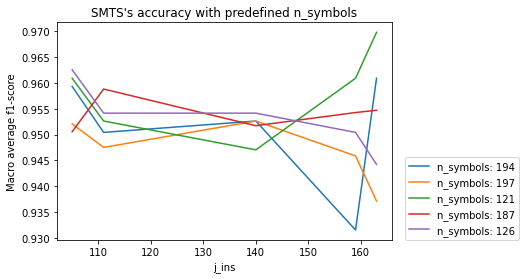

In [36]:
from utils.plot_utils import plot_score

macro_avg_f1_scores = dict(map(
    lambda z: (z, {'score': all_reports[z]['macro avg']['f1-score'][0],
                   'std': all_reports[z]['macro avg']['f1-score'][1]}),
    all_reports
))

plot_score(
    [macro_avg_f1_scores],
    ('j_ins', 'n_symbols'),
    'SMTS',
    inverse=False,
    mode='score',
    in_same_graphic=True,
    accuracy_mode='accuracy',
    metric_name='Macro Average F1-Score'
)


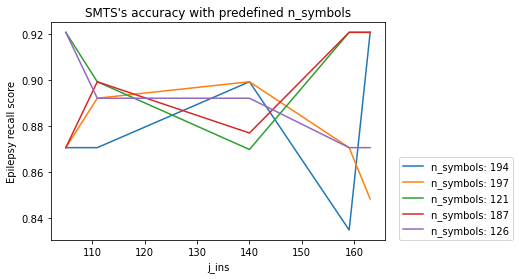

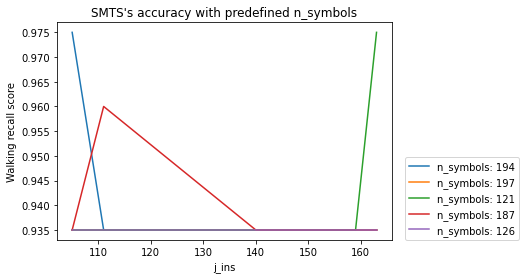

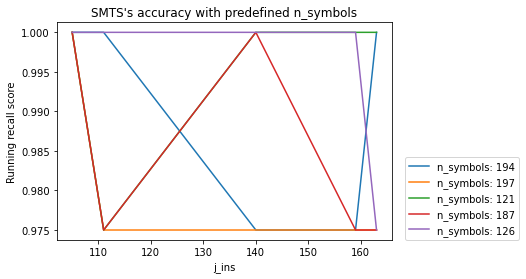

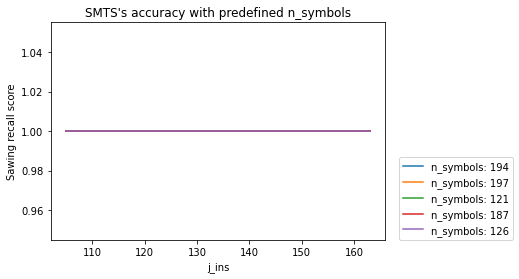

In [38]:
epilepsy_recall_scores = dict(map(
    lambda z: (z, {'score': all_reports[z]['epilepsy']['recall'][0],
                   'std': all_reports[z]['epilepsy']['recall'][1]}),
    all_reports
))

walking_recall_scores = dict(map(
    lambda z: (z, {'score': all_reports[z]['walking']['recall'][0],
                   'std': all_reports[z]['walking']['recall'][1]}),
    all_reports
))

running_recall_scores = dict(map(
    lambda z: (z, {'score': all_reports[z]['running']['recall'][0],
                   'std': all_reports[z]['running']['recall'][1]}),
    all_reports
))

sawing_recall_scores = dict(map(
    lambda z: (z, {'score': all_reports[z]['sawing']['recall'][0],
                   'std': all_reports[z]['sawing']['recall'][1]}),
    all_reports
))

plot_score(
    [epilepsy_recall_scores],
    ('j_ins', 'n_symbols'),
    'SMTS',
    inverse=False,
    mode='score',
    in_same_graphic=True,
    accuracy_mode='accuracy',
    metric_name='Epilepsy recall score'
)

plot_score(
    [walking_recall_scores],
    ('j_ins', 'n_symbols'),
    'SMTS',
    inverse=False,
    mode='score',
    in_same_graphic=True,
    accuracy_mode='accuracy',
    metric_name='Walking recall score'
)

plot_score(
    [running_recall_scores],
    ('j_ins', 'n_symbols'),
    'SMTS',
    inverse=False,
    mode='score',
    in_same_graphic=True,
    accuracy_mode='accuracy',
    metric_name='Running recall score'
)

plot_score(
    [sawing_recall_scores],
    ('j_ins', 'n_symbols'),
    'SMTS',
    inverse=False,
    mode='score',
    in_same_graphic=True,
    accuracy_mode='accuracy',
    metric_name='Sawing recall score'
)


# <font color=#cd0000> Evaluación sobre el conjunto de validación </font>
- Vamos a llevar a cabo la evaluación final sobre el conjunto de validación (esto es lo que irá al apartado de ``Pruebas y Resultados`` de la memoria).

## <font color=#cd0000> Entrenamiento </font>

In [39]:
from smts_implementation.smts import SMTS

clf = SMTS(
    j_ins=163,
    n_symbols=121,
    class_weight=class_weights,
    random_state=SEED
)
clf.fit(X_train, y_train)


## <font color=#cd0000> Clasificación </font>

In [40]:
from sklearn.metrics import confusion_matrix, classification_report

y_pred = clf.predict(X_test)
y_true = X_test.assign(class_name=y_test).groupby('id')\
    .first()['class_name'].to_numpy()

print(confusion_matrix(y_true, y_pred))
print(classification_report(y_true, y_pred, zero_division=0))


[[32  0  1  1]
 [ 1 34  2  0]
 [ 0  0 30  0]
 [ 0  0  0 37]]
              precision    recall  f1-score   support

    epilepsy       0.97      0.94      0.96        34
     running       1.00      0.92      0.96        37
      sawing       0.91      1.00      0.95        30
     walking       0.97      1.00      0.99        37

    accuracy                           0.96       138
   macro avg       0.96      0.97      0.96       138
weighted avg       0.97      0.96      0.96       138



# <font color=#cd0000> Conclusiones </font>
- Observamos unos resultados ligeramente mejores con respecto a aplicar únicamente una ``Codificación Simbólica``.